# Seattle Library Classification Problem

This dataset includes monthly snapshot of all of the physical items in the Seattle Public Library’s collection. Consistent monthly data begins with a snapshot taken August1, 2016, continuing to the present. Additionally, this dataset contains snapshots taken on: January 1 in the years 2012, 2013, 2014, and 2016.

## Data Schema

Initial state of the datasets (with inferSchema):

**Seattle Library Dataframe Column Description**


| Column     | Type       | Description |
|--------  |---------  |: --------- |
| **BibNum** | Integer | The unique identifier for a cataloged item within the Library's Integrated Library System (ILS). |
| **Title** | String | The full title of an item. |
| **Author** | String | The name of the first author of the title, if applicable. |
| **ISBN** | String | Comma-delimited list of ISBN(s) for this title. |
| **PublicationYear** | String | Date (year) of publication. |
| **Publisher** | String | The name of the publishing company for this item. |
| **Subjects** | String | A comma-separated list of the subject authority records associated with the title, including Motion Pictures, Computer Programming, etc. Typically these are highly specific. |
| **ItemType** | String | Horizon item type. Look up value descriptions in HorizonCodes using CodeType "ItemType". |
| **ItemCollection** | String | Collection code for this item. Look up value descriptions in: Integrated Library System (ILS) Data Dictionary |
| **FloatingItem** | String | Label that indicates if an item floats - Floating collections do not assign items to "owning" locations and instead allows those itemsto move around the library system based on where patrons are checking them out from and returning them to |
| **ItemLocation** | String | Location that owned the item at the time of snapshot. 3-letter code. Note: as of 2017, some items are "FLOATING" which means they don't necessarily belong to a specific branch. Location of given copy could change based on where the item is returned. |
| **ReportDate** | String | The date when this item count was collected from the ILS (Horizon). |
| **ItemCount** | String | The number of items in this location, collection, item type, and item status as of the report date. |



**ItemCollection Dataframe Column Description** (an auxiliary dataset)


| Column     | Type       
|--------  |---------  |
| **CodeType** | String |
| **Code** | String | 
| **Description** | String |
| **CollectionInventoryIncluded** | String | 
| **FormatGroup** | String | 
| **FormatSubgroup** | String | 
| **CategoryGroup** | String | 
| **CategorySubgroup** | String | 
| **AgeGroup** | String | 

Needed imports to implement the solution:

In [64]:
import os

import pandas as pd
import scipy as sc
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt

from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder, VectorIndexer, CountVectorizer, RFormula, RegexTokenizer, StopWordsRemover, Tokenizer, HashingTF, IDF
from pyspark.ml.classification import NaiveBayes, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql.types import *
from pyspark.sql.functions import isnan, when, count, col, countDistinct, split, expr, array_sort, concat_ws

import warnings
warnings.filterwarnings("ignore")

## Useful functions

In [2]:
def ScatterPlot(df, width, height):
    plt.figure(figsize=(width, height))
    plt.pcolor(df)
    plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
    plt.show()

In [3]:
! pwd
! ls -la
! head -n 1 library-collection-inventory-sample.csv
! tail -n 1 library-collection-inventory-sample.csv

/home/big/Desktop/ABD Project
total 15569352
drwxrwxr-x 7 big big        4096 mai 22 03:57  .
drwxr-xr-x 5 big big        4096 mai 15 19:58  ..
-rw-rw-r-- 1 big big  4051295256 mai 11 04:07  archive.zip
drwxr-xr-x 2 big big        4096 mai 16 18:14  cleaned-library-dataset
drwxr-xr-x 2 big big        4096 mai 22 03:13  clean-library-final-dataset
-rw-rw-r-- 1 big big       37147 dez  1  2019  CollectionInventory_Codes_EXCLUDED_INCLUDED.xlsx
-rw-rw-r-- 1 big big        6959 mai 19 23:33  Exercising.ipynb
drwxrwxr-x 8 big big        4096 mai 21 19:33  .git
-rw-rw-r-- 1 big big         108 mai 21 19:31  .gitignore
-rw-rw-r-- 1 big big       41917 mai 12 21:46  Integrated_Library_System__ILS__Data_Dictionary.csv
drwxrwxr-x 2 big big        4096 mai 20 16:37  .ipynb_checkpoints
-rw-rw-r-- 1 big big       34175 mai 16 15:10  ItemCollection.csv
-rw-rw-r-- 1 big big        8120 mai 16 15:10  ItemType.csv
-rw-rw-r-- 1 big big 11764863851 dez  1  2019  library-collection-inventory.csv
-rw-rw-r--

## Data Ingestion

We will provide the specification for the schema of the main data frame (based on the table at the beginning of the notebook).

In [4]:
customSchema = StructType([
  StructField("BibNum", IntegerType(), True),
  StructField("Title", StringType(), True),
  StructField("Author", StringType(), True),
  StructField("ISBN", StringType(), True),
  StructField("PublicationYear", StringType(), True),
  StructField("Publisher", StringType(), True),
  StructField("Subjects", StringType(), True),
  StructField("ItemType", StringType(), True),
  StructField("ItemCollection", StringType(), True),
  StructField("FloatingItem", StringType(), True),
  StructField("ItemLocation", StringType(), True),
  StructField("ReportDate", StringType(), True),
  StructField("ItemCount", StringType(), True)]
)

Read the csv files, of the two needed datasets to a spark dataframe

In [5]:
library_collection_filepath = "library-collection-inventory-sample.csv"
item_collection_filepath = "ItemCollection.csv"
library_collection_dfraw = spark.read.csv(library_collection_filepath, schema=customSchema)
item_collection_dfraw = spark.read.csv(item_collection_filepath, header="true", inferSchema="true")

## Exploratory Data Analysis

Let us get some insight from data.

In [6]:
library_collection_rawcols = library_collection_dfraw.columns
library_collection_dfraw.printSchema()
print(library_collection_rawcols)
library_collection_dfraw.count()

root
 |-- BibNum: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- PublicationYear: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Subjects: string (nullable = true)
 |-- ItemType: string (nullable = true)
 |-- ItemCollection: string (nullable = true)
 |-- FloatingItem: string (nullable = true)
 |-- ItemLocation: string (nullable = true)
 |-- ReportDate: string (nullable = true)
 |-- ItemCount: string (nullable = true)

['BibNum', 'Title', 'Author', 'ISBN', 'PublicationYear', 'Publisher', 'Subjects', 'ItemType', 'ItemCollection', 'FloatingItem', 'ItemLocation', 'ReportDate', 'ItemCount']


355807

In [7]:
library_collection_dfraw.show(3)

+------+--------------------+--------------------+----------+---------------+--------------------+--------------------+--------+--------------+------------+------------+--------------------+---------+
|BibNum|               Title|              Author|      ISBN|PublicationYear|           Publisher|            Subjects|ItemType|ItemCollection|FloatingItem|ItemLocation|          ReportDate|ItemCount|
+------+--------------------+--------------------+----------+---------------+--------------------+--------------------+--------+--------------+------------+------------+--------------------+---------+
|  4750|My maternal ances...|  Wood, Melba, 1913-|      null|   [1968]-1987.|            M. Wood,|         Hale family|    arbk|         caref|          NA|         cen|2017-09-01T00:00:...|        1|
|  6720|The White House m...|      Feiffer, Jules|      null|         [1970]|         Grove Press|                null|    acbk|          canf|          NA|         cen|2017-09-01T00:00:...|      

In [8]:
item_collection_rawcols = item_collection_dfraw.columns
item_collection_dfraw.printSchema()
print(item_collection_rawcols)
item_collection_dfraw.count()

root
 |-- CodeType: string (nullable = true)
 |-- Code: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- CollectionInventoryIncluded: string (nullable = true)
 |-- FormatGroup: string (nullable = true)
 |-- FormatSubgroup: string (nullable = true)
 |-- CategoryGroup: string (nullable = true)
 |-- CategorySubgroup: string (nullable = true)
 |-- AgeGroup: string (nullable = true)

['CodeType', 'Code', 'Description', 'CollectionInventoryIncluded', 'FormatGroup', 'FormatSubgroup', 'CategoryGroup', 'CategorySubgroup', 'AgeGroup']


429

In [9]:
library_collection_dfraw.show(3)

+------+--------------------+--------------------+----------+---------------+--------------------+--------------------+--------+--------------+------------+------------+--------------------+---------+
|BibNum|               Title|              Author|      ISBN|PublicationYear|           Publisher|            Subjects|ItemType|ItemCollection|FloatingItem|ItemLocation|          ReportDate|ItemCount|
+------+--------------------+--------------------+----------+---------------+--------------------+--------------------+--------+--------------+------------+------------+--------------------+---------+
|  4750|My maternal ances...|  Wood, Melba, 1913-|      null|   [1968]-1987.|            M. Wood,|         Hale family|    arbk|         caref|          NA|         cen|2017-09-01T00:00:...|        1|
|  6720|The White House m...|      Feiffer, Jules|      null|         [1970]|         Grove Press|                null|    acbk|          canf|          NA|         cen|2017-09-01T00:00:...|      

## Data of Interest

We may just want to deal with some certain columns of the data.

In [10]:
for col in library_collection_rawcols:
    library_collection_dfraw.select(col).show(5)

+------+
|BibNum|
+------+
|  4750|
|  6720|
|  6845|
|  7118|
|  7886|
+------+
only showing top 5 rows

+--------------------+
|               Title|
+--------------------+
|My maternal ances...|
|The White House m...|
|Autumn of glory; ...|
|Variety music cav...|
|A bibliography of...|
+--------------------+
only showing top 5 rows

+--------------------+
|              Author|
+--------------------+
|  Wood, Melba, 1913-|
|      Feiffer, Jules|
|Connelly, Thomas ...|
|Mattfeld, Julius,...|
|Van Derhoof, Jack...|
+--------------------+
only showing top 5 rows

+----------+
|      ISBN|
+----------+
|      null|
|      null|
|0807104450|
|0139407189|
|087875007X|
+----------+
only showing top 5 rows

+---------------+
|PublicationYear|
+---------------+
|   [1968]-1987.|
|         [1970]|
|         [1971]|
|         [1971]|
|          1971.|
+---------------+
only showing top 5 rows

+--------------------+
|           Publisher|
+--------------------+
|            M. Wood,|
|        

In [11]:
for col in item_collection_rawcols:
    item_collection_dfraw.select(col).show(5)

+--------------+
|      CodeType|
+--------------+
|ItemCollection|
|ItemCollection|
|ItemCollection|
|ItemCollection|
|ItemCollection|
+--------------+
only showing top 5 rows

+-------+
|   Code|
+-------+
| caaero|
|caaeroc|
|caaeroo|
|caaerop|
|caaerov|
+-------+
only showing top 5 rows

+--------------------+
|         Description|
+--------------------+
|  Cs9-AERO Reference|
|     Cs9-AERO Valmat|
|   Cs9-AERO Oversize|
|Cs9-AERO Periodicals|
|Cs9-AERO Valmat O...|
+--------------------+
only showing top 5 rows

+---------------------------+
|CollectionInventoryIncluded|
+---------------------------+
|                        YES|
|                        YES|
|                        YES|
|                        YES|
|                        YES|
+---------------------------+
only showing top 5 rows

+-----------+
|FormatGroup|
+-----------+
|      Print|
|      Print|
|      Print|
|      Print|
|      Print|
+-----------+
only showing top 5 rows

+--------------+
|FormatSubgr

Distinct values per column in the library collection dataset

In [14]:
df_aux_distinct=library_collection_dfraw.agg(*(countDistinct(col(c)).alias(c) for c in library_collection_dfraw.columns))
pd.set_option('display.max_columns', None)
pd_df=pd.DataFrame(df_aux_distinct.take(1), columns=library_collection_dfraw.columns)
pd_df

,BibNum,Title,Author,ISBN,PublicationYear,Publisher,Subjects,ItemType,ItemCollection,FloatingItem,ItemLocation,ReportDate,ItemCount
0,229187,226493,103386,168474,5321,43060,197065,674,594,277,207,165,222


<AxesSubplot:title={'center':'Distinct values for each column'}>

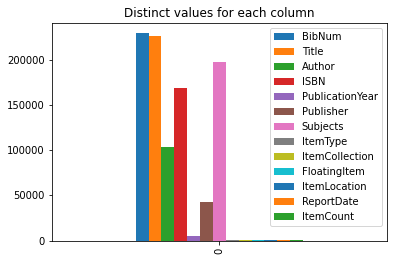

In [15]:
pd_df.plot(kind="bar", title="Distinct values for each column")

Distinct values per column in the item collection dataset

In [16]:
df_aux_distinct=item_collection_dfraw.agg(*(countDistinct(col(c)).alias(c) for c in item_collection_dfraw.columns))
pd.set_option('display.max_columns', None)
pd_df=pd.DataFrame(df_aux_distinct.take(1), columns=item_collection_dfraw.columns)
pd_df

,CodeType,Code,Description,CollectionInventoryIncluded,FormatGroup,FormatSubgroup,CategoryGroup,CategorySubgroup,AgeGroup
0,1,429,424,2,5,15,10,7,3


<AxesSubplot:title={'center':'Distinct values for each column'}>

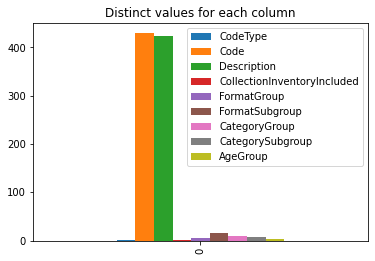

In [17]:
pd_df.plot(kind="bar", title="Distinct values for each column")

Number of nulls and missing values per columns in the library collection dataset

In [18]:
df_aux_nulls=library_collection_dfraw.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in library_collection_dfraw.columns])
pd.set_option('display.max_columns', None)
pd.DataFrame(df_aux_nulls.take(5), columns=library_collection_dfraw.columns)

,BibNum,Title,Author,ISBN,PublicationYear,Publisher,Subjects,ItemType,ItemCollection,FloatingItem,ItemLocation,ReportDate,ItemCount
0,0,1843,54965,80225,4477,2954,8322,125,118,114,109,111,112


Number of nulls and missing values per columns in the item collection dataset

In [19]:
df_aux_nulls=item_collection_dfraw.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in item_collection_dfraw.columns])
pd.set_option('display.max_columns', None)
pd.DataFrame(df_aux_nulls.take(5), columns=item_collection_dfraw.columns)

,CodeType,Code,Description,CollectionInventoryIncluded,FormatGroup,FormatSubgroup,CategoryGroup,CategorySubgroup,AgeGroup
0,0,0,0,0,0,28,0,385,0


In [20]:
library_collection_cols_to_drop = ["BibNum", "Title", "ISBN", "PublicationYear", "FloatingItem", "ItemLocation", "ReportDate", "ItemCount"] 
library_collection_cols_of_interest = [x for x in library_collection_rawcols if x not in library_collection_cols_to_drop]
library_collection_cols_of_interest

['Author', 'Publisher', 'Subjects', 'ItemType', 'ItemCollection']

In [21]:
item_collection_dfraw.select("FormatGroup").distinct().show()

+-----------+
|FormatGroup|
+-----------+
|  Equipment|
|      Media|
|      Other|
|      Print|
| Electronic|
+-----------+



In [22]:
item_collection_dfraw.select("FormatSubgroup").distinct().show()

+--------------+
|FormatSubgroup|
+--------------+
|    Periodical|
|           Kit|
|           Art|
|          null|
|Audiobook Tape|
|          Book|
|          Film|
|      Document|
|     Data Disc|
|    Audio Tape|
|Audiobook Disc|
|    Video Disc|
|        Folder|
|    Video Tape|
|    Audio Disc|
|   Music Score|
+--------------+



In [23]:
item_collection_cols_to_drop = ["CodeType", "CollectionInventoryIncluded", "CategorySubgroup", "FormatGroup"] 
item_collection_cols_of_interest = [x for x in item_collection_rawcols if x not in item_collection_cols_to_drop]
item_collection_cols_of_interest

['Code', 'Description', 'FormatSubgroup', 'CategoryGroup', 'AgeGroup']

In [24]:
library_collection_dfraw_interest = library_collection_dfraw.select(library_collection_cols_of_interest)
library_collection_dfraw_interest.printSchema()
library_collection_dfraw_interest.show()

root
 |-- Author: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Subjects: string (nullable = true)
 |-- ItemType: string (nullable = true)
 |-- ItemCollection: string (nullable = true)

+--------------------+--------------------+--------------------+--------+--------------+
|              Author|           Publisher|            Subjects|ItemType|ItemCollection|
+--------------------+--------------------+--------------------+--------+--------------+
|  Wood, Melba, 1913-|            M. Wood,|         Hale family|    arbk|         caref|
|      Feiffer, Jules|         Grove Press|                null|    acbk|          canf|
|Connelly, Thomas ...|Louisiana State U...|Confederate State...|    acbk|          canf|
|Mattfeld, Julius,...|       Prentice-Hall|Popular music Uni...|    arbk|         caref|
|Van Derhoof, Jack...|  Whitston Pub. Co.,|Historical fictio...|    arbk|          cs8r|
|United States. Co...|[For sale by the ...|Erotica, Obscenit...|    acbk|    

In [25]:
item_collection_dfraw_interest = item_collection_dfraw.select(item_collection_cols_of_interest)
item_collection_dfraw_interest.printSchema()
item_collection_dfraw_interest.show()

root
 |-- Code: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- FormatSubgroup: string (nullable = true)
 |-- CategoryGroup: string (nullable = true)
 |-- AgeGroup: string (nullable = true)

+-------+--------------------+--------------+-------------+--------+
|   Code|         Description|FormatSubgroup|CategoryGroup|AgeGroup|
+-------+--------------------+--------------+-------------+--------+
| caaero|  Cs9-AERO Reference|          Book|    Reference|   Adult|
|caaeroc|     Cs9-AERO Valmat|          Book|   Nonfiction|   Adult|
|caaeroo|   Cs9-AERO Oversize|          Book|   Nonfiction|   Adult|
|caaerop|Cs9-AERO Periodicals|          Book|   Nonfiction|   Adult|
|caaerov|Cs9-AERO Valmat O...|          Book|   Nonfiction|   Adult|
|caatlas|         CA9-Atlases|          Book|   Nonfiction|   Adult|
|    cab|       CA9-Biography|          Book|   Nonfiction|   Adult|
|  cabob|   CA-Books on Bikes|          Book|Miscellaneous|   Adult|
| cabocd|CA7-Books on CD,

In the auxiliary dataset we can drop filter by FormatSubgroup. We only want to classify books, so:

In [26]:
item_collection_dfraw_interest = item_collection_dfraw_interest \
            .filter(item_collection_dfraw_interest.FormatSubgroup == "Book")

In [27]:
item_collection_dfraw_interest.select("FormatSubgroup").distinct().show()

+--------------+
|FormatSubgroup|
+--------------+
|          Book|
+--------------+



Now we can exclude the "FormatSubgroup" column:

In [28]:
item_collection_cols_of_interest = [x for x in item_collection_dfraw_interest.columns if x not in ["FormatSubgroup"]]
item_collection_dfraw_interest=item_collection_dfraw_interest.select(item_collection_cols_of_interest)

In [29]:
item_collection_dfraw_interest.printSchema()

root
 |-- Code: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- CategoryGroup: string (nullable = true)
 |-- AgeGroup: string (nullable = true)



In [30]:
item_collection_dfraw_interest.count()

289

## Data Cleansing 

Once data of interest is established, the goal now is to get a clean dataset so we can proceed with our analysis.

### Nulls

drop nulls in the library collection dataframe

In [31]:
library_collection_dfraw_interest_clean1=library_collection_dfraw_interest.dropna()

In [32]:
library_collection_dfraw_interest_clean1.count()

294230

In [33]:
df_aux_nulls2=library_collection_dfraw_interest_clean1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in library_collection_dfraw_interest_clean1.columns])
pd.set_option('display.max_columns', None)
pd.DataFrame(df_aux_nulls2.take(5), columns=library_collection_dfraw_interest_clean1.columns)

,Author,Publisher,Subjects,ItemType,ItemCollection
0,0,0,0,0,0


drop nulls in the item collection dataframe

In [34]:
item_collection_dfraw_interest_clean1=item_collection_dfraw_interest.dropna()

In [35]:
item_collection_dfraw_interest_clean1.count()

289

In [36]:
df_aux_nulls3=item_collection_dfraw_interest_clean1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in item_collection_dfraw_interest_clean1.columns])
pd.set_option('display.max_columns', None)
pd.DataFrame(df_aux_nulls3.take(5), columns=item_collection_dfraw_interest_clean1.columns)

,Code,Description,CategoryGroup,AgeGroup
0,0,0,0,0


### Joining the dataframes

To cross all the information we will join both dataframes through the item collection code:

In [37]:
df_main = library_collection_dfraw_interest_clean1.join(item_collection_dfraw_interest_clean1, library_collection_dfraw_interest_clean1.ItemCollection==item_collection_dfraw_interest_clean1.Code)

Now we're going to work with the df_main dataframe

In [38]:
df_main.printSchema()
df_main.show()

root
 |-- Author: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Subjects: string (nullable = true)
 |-- ItemType: string (nullable = true)
 |-- ItemCollection: string (nullable = true)
 |-- Code: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- CategoryGroup: string (nullable = true)
 |-- AgeGroup: string (nullable = true)

+--------------------+--------------------+--------------------+--------+--------------+------+--------------------+-------------+--------+
|              Author|           Publisher|            Subjects|ItemType|ItemCollection|  Code|         Description|CategoryGroup|AgeGroup|
+--------------------+--------------------+--------------------+--------+--------------+------+--------------------+-------------+--------+
|  Wood, Melba, 1913-|            M. Wood,|         Hale family|    arbk|         caref| caref|        CA-Reference|    Reference|   Adult|
|Connelly, Thomas ...|Louisiana State U...|Confederate State...| 

### Data types & Feature transformation

A lot of work in a machine learning project comes down to it. Whether we like it or not we spend 95% of our time on generating that feature vector that will bring out the best in our data.

In [39]:
for col in df_main.columns:
    df_main.select(col).show(5)

+--------------------+
|              Author|
+--------------------+
|  Wood, Melba, 1913-|
|Connelly, Thomas ...|
|Mattfeld, Julius,...|
|Van Derhoof, Jack...|
|United States. Co...|
+--------------------+
only showing top 5 rows

+--------------------+
|           Publisher|
+--------------------+
|            M. Wood,|
|Louisiana State U...|
|       Prentice-Hall|
|  Whitston Pub. Co.,|
|[For sale by the ...|
+--------------------+
only showing top 5 rows

+--------------------+
|            Subjects|
+--------------------+
|         Hale family|
|Confederate State...|
|Popular music Uni...|
|Historical fictio...|
|Erotica, Obscenit...|
+--------------------+
only showing top 5 rows

+--------+
|ItemType|
+--------+
|    arbk|
|    acbk|
|    arbk|
|    arbk|
|    acbk|
+--------+
only showing top 5 rows

+--------------+
|ItemCollection|
+--------------+
|         caref|
|          canf|
|         caref|
|          cs8r|
|          canf|
+--------------+
only showing top 5 rows

+-

In [42]:
print("Total registers: " + str(df_main.count()))
print("Distincts:")
df_main_distinct=df_main.agg(*(countDistinct(col(c)).alias(c) for c in df_main.columns))
pd.set_option('display.max_columns', None)
pd.DataFrame(df_main_distinct.take(1), columns=df_main_distinct.columns)

Total registers: 263914
Distincts:


,Author,Publisher,Subjects,ItemType,ItemCollection,Code,Description,CategoryGroup,AgeGroup
0,92871,28297,153138,29,183,183,183,6,3


Code and description should be the same we can exclude it now. One of the join factors can be excluded two, since they're the same.

In [43]:
df_main_columns = ["Author", "Publisher", "Subjects", "ItemType", "ItemCollection", "CategoryGroup", "AgeGroup"]
df_main=df_main.select(df_main_columns)

In [44]:
df_main.printSchema()

root
 |-- Author: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Subjects: string (nullable = true)
 |-- ItemType: string (nullable = true)
 |-- ItemCollection: string (nullable = true)
 |-- CategoryGroup: string (nullable = true)
 |-- AgeGroup: string (nullable = true)



In [45]:
df_main=df_main.withColumn("Subjects",split(col("Subjects"), ",\s*").cast(ArrayType(StringType())).alias("Subjects"))

In [46]:
df_main.printSchema()

root
 |-- Author: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Subjects: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ItemType: string (nullable = true)
 |-- ItemCollection: string (nullable = true)
 |-- CategoryGroup: string (nullable = true)
 |-- AgeGroup: string (nullable = true)



In [47]:
df_main.tail(5)

[Row(Author='McBratney, Sam', Publisher='Shui di wen hua,', Subjects=['Death Juvenile fiction', 'Grief Juvenile fiction', 'Mothers Death Juvenile fiction', 'Bereavement Juvenile fiction', 'Picture books for children', 'Chinese language materials'], ItemType='jcbk', ItemCollection='ncln', CategoryGroup='Language', AgeGroup='Juvenile'),
 Row(Author='Reedy, Brad M.', Publisher='Regan Arts,', Subjects=['Child rearing'], ItemType='acbk', ItemCollection='canf', CategoryGroup='Nonfiction', AgeGroup='Adult'),
 Row(Author='Ḥārithī, Jūkhah', Publisher='Catapult,', Subjects=['Sisters Oman Fiction', 'Oman Social life and customs Fiction', 'Historical fiction', 'Domestic fiction'], ItemType='acbk', ItemCollection='nafic', CategoryGroup='Fiction', AgeGroup='Adult'),
 Row(Author='Corr, Christopher', Publisher="Frances Lincoln Children's Books,", Subjects=['Fir Juvenile fiction', 'Christmas tree Juvenile fiction', 'Christmas fiction', 'Picture books'], ItemType='jcbk', ItemCollection='nchol', Category

Order the arrays of strings inside the Subjects column:

In [52]:
df_main=df_main.withColumn("Subjects",array_sort(col("Subjects")))
df_main.tail(5)

[Row(Author='McBratney, Sam', Publisher='Shui di wen hua,', Subjects=['Bereavement Juvenile fiction', 'Chinese language materials', 'Death Juvenile fiction', 'Grief Juvenile fiction', 'Mothers Death Juvenile fiction', 'Picture books for children'], ItemType='jcbk', ItemCollection='ncln', CategoryGroup='Language', AgeGroup='Juvenile'),
 Row(Author='Reedy, Brad M.', Publisher='Regan Arts,', Subjects=['Child rearing'], ItemType='acbk', ItemCollection='canf', CategoryGroup='Nonfiction', AgeGroup='Adult'),
 Row(Author='Ḥārithī, Jūkhah', Publisher='Catapult,', Subjects=['Domestic fiction', 'Historical fiction', 'Oman Social life and customs Fiction', 'Sisters Oman Fiction'], ItemType='acbk', ItemCollection='nafic', CategoryGroup='Fiction', AgeGroup='Adult'),
 Row(Author='Corr, Christopher', Publisher="Frances Lincoln Children's Books,", Subjects=['Christmas fiction', 'Christmas tree Juvenile fiction', 'Fir Juvenile fiction', 'Picture books'], ItemType='jcbk', ItemCollection='nchol', Category

In [53]:
df_main.printSchema()

root
 |-- Author: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Subjects: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ItemType: string (nullable = true)
 |-- ItemCollection: string (nullable = true)
 |-- CategoryGroup: string (nullable = true)
 |-- AgeGroup: string (nullable = true)



Convert the subjects column back to StringType

In [56]:
df_main=df_main.withColumn("Subjects", concat_ws(",",col("Subjects")))

In [57]:
df_main.tail(5)

[Row(Author='McBratney, Sam', Publisher='Shui di wen hua,', Subjects='Bereavement Juvenile fiction,Chinese language materials,Death Juvenile fiction,Grief Juvenile fiction,Mothers Death Juvenile fiction,Picture books for children', ItemType='jcbk', ItemCollection='ncln', CategoryGroup='Language', AgeGroup='Juvenile'),
 Row(Author='Reedy, Brad M.', Publisher='Regan Arts,', Subjects='Child rearing', ItemType='acbk', ItemCollection='canf', CategoryGroup='Nonfiction', AgeGroup='Adult'),
 Row(Author='Ḥārithī, Jūkhah', Publisher='Catapult,', Subjects='Domestic fiction,Historical fiction,Oman Social life and customs Fiction,Sisters Oman Fiction', ItemType='acbk', ItemCollection='nafic', CategoryGroup='Fiction', AgeGroup='Adult'),
 Row(Author='Corr, Christopher', Publisher="Frances Lincoln Children's Books,", Subjects='Christmas fiction,Christmas tree Juvenile fiction,Fir Juvenile fiction,Picture books', ItemType='jcbk', ItemCollection='nchol', CategoryGroup='Fiction', AgeGroup='Juvenile'),
 R

In [58]:
df_main.printSchema()

root
 |-- Author: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Subjects: string (nullable = false)
 |-- ItemType: string (nullable = true)
 |-- ItemCollection: string (nullable = true)
 |-- CategoryGroup: string (nullable = true)
 |-- AgeGroup: string (nullable = true)



In [59]:
df_main_distinct=df_main.agg(*(countDistinct(col(c)).alias(c) for c in df_main.columns))
pd.set_option('display.max_columns', None)
pd.DataFrame(df_main_distinct.take(1), columns=df_main_distinct.columns)

,Author,Publisher,Subjects,ItemType,ItemCollection,CategoryGroup,AgeGroup
0,92871,28297,150654,29,183,6,3


As we can see we were able to reduce the distinct values in the "Subjects" column

#### RegexTokenizer & StopWordsRemover

In [60]:
for col in df_main_columns:
    tk = RegexTokenizer(pattern="[a-zA-Z]+", inputCol=col, outputCol="temp1", gaps=False)
    sw = StopWordsRemover(inputCol="temp1", outputCol="temp2")
    pipeline = Pipeline(stages=[tk, sw])
    df_main = pipeline.fit(df_main).transform(df_main) \
        .withColumn(col, expr('concat_ws(" ", array_distinct(temp2))')) \
        .drop("temp1", "temp2")

In [61]:
pd.set_option('display.max_columns', None)
pd.DataFrame(df_main.take(5), columns=df_main_columns)

,Author,Publisher,Subjects,ItemType,ItemCollection,CategoryGroup,AgeGroup
0,wood melba,m wood,hale family,arbk,caref,reference,adult
1,connelly thomas lawrence,louisiana state university press,confederate states america army department ten...,acbk,canf,nonfiction,adult
2,mattfeld julius,prentice hall,music united states chronology popular bibliog...,arbk,caref,reference,adult
3,van derhoof jack warner,whitston pub co,historical fiction american bibliography engli...,arbk,cs r,reference,adult
4,united states commission obscenity pornography,sale supt docs u govt print,erotica obscenity law united states pornograph...,acbk,canf,nonfiction,adult


In [65]:
df_main=df_main.select([when(col(c)=="",None).otherwise(col(c)).alias(c) for c in df_main.columns])

In [67]:
df_main=df_main.dropna()

In [68]:
print("Total registers: " + str(df_main.count()))
print("Distincts:")
df_main_distinct=df_main.agg(*(countDistinct(col(c)).alias(c) for c in df_main.columns))
pd.set_option('display.max_columns', None)
pd.DataFrame(df_main_distinct.take(5), columns=df_main_distinct.columns)

Total registers: 263890
Distincts:


,Author,Publisher,Subjects,ItemType,ItemCollection,CategoryGroup,AgeGroup
0,90399,24097,147795,29,164,6,3


### Saving the clean dataset

In [69]:
cleanfilename = "clean-library-final-dataset"
df_main.write.mode("overwrite").parquet(cleanfilename)
#later we can use spark.read.parquet()

In [70]:
! ls -la clean-library-final-dataset

total 13240
drwxr-xr-x 2 big big    4096 mai 22 04:06 .
drwxrwxr-x 7 big big    4096 mai 22 04:06 ..
-rw-r--r-- 1 big big 3462923 mai 22 04:06 part-00000-89c86db7-ab35-4165-8f84-b5c492f5efa1-c000.snappy.parquet
-rw-r--r-- 1 big big   27064 mai 22 04:06 .part-00000-89c86db7-ab35-4165-8f84-b5c492f5efa1-c000.snappy.parquet.crc
-rw-r--r-- 1 big big 3509121 mai 22 04:06 part-00001-89c86db7-ab35-4165-8f84-b5c492f5efa1-c000.snappy.parquet
-rw-r--r-- 1 big big   27424 mai 22 04:06 .part-00001-89c86db7-ab35-4165-8f84-b5c492f5efa1-c000.snappy.parquet.crc
-rw-r--r-- 1 big big 3539546 mai 22 04:06 part-00002-89c86db7-ab35-4165-8f84-b5c492f5efa1-c000.snappy.parquet
-rw-r--r-- 1 big big   27664 mai 22 04:06 .part-00002-89c86db7-ab35-4165-8f84-b5c492f5efa1-c000.snappy.parquet.crc
-rw-r--r-- 1 big big 2913100 mai 22 04:06 part-00003-89c86db7-ab35-4165-8f84-b5c492f5efa1-c000.snappy.parquet
-rw-r--r-- 1 big big   22768 mai 22 04:06 .part-00003-89c86db7-ab35-4165-8f84-b5c492f5efa1-c000.snappy.parquet.crc

### Final overview & Basic Statistics

In [71]:
# read the parquet file saved in the previous steps
df_main=spark.read.parquet(cleanfilename)

In [72]:
df_main.printSchema()

root
 |-- Author: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Subjects: string (nullable = true)
 |-- ItemType: string (nullable = true)
 |-- ItemCollection: string (nullable = true)
 |-- CategoryGroup: string (nullable = true)
 |-- AgeGroup: string (nullable = true)



#### StringIndexer & OneHotEncoder

In [74]:
categorical_cols = df_main.columns
index_output_cols = [ x + "Index" for x in categorical_cols]
ohe_output_cols = [ x + "OHE" for x in categorical_cols]

print("Categorical columns: " + str(categorical_cols))
print("Indexed columns: " + str(index_output_cols))
print("Vector columns: " + str(ohe_output_cols))

string_indexer = StringIndexer(inputCols=categorical_cols, outputCols=index_output_cols, handleInvalid="skip")  # skip é importante, para usar mais tarde com o DF de teste
df_main_indexed = string_indexer.fit(df_main).transform(df_main)

ohe_encoder = OneHotEncoder(inputCols=index_output_cols, outputCols=ohe_output_cols)
df_main_encoded = ohe_encoder.fit(df_main_indexed).transform(df_main_indexed)

vector_col = "features"

assembler_inputs = index_output_cols
vec_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol=vector_col)

Categorical columns: ['Author', 'Publisher', 'Subjects', 'ItemType', 'ItemCollection', 'CategoryGroup', 'AgeGroup']
Indexed columns: ['AuthorIndex', 'PublisherIndex', 'SubjectsIndex', 'ItemTypeIndex', 'ItemCollectionIndex', 'CategoryGroupIndex', 'AgeGroupIndex']
Vector columns: ['AuthorOHE', 'PublisherOHE', 'SubjectsOHE', 'ItemTypeOHE', 'ItemCollectionOHE', 'CategoryGroupOHE', 'AgeGroupOHE']


In [78]:
pipeline = Pipeline(stages=[string_indexer, ohe_encoder, vec_assembler])
df_main_indexed_encoded=pipeline.fit(df_main).transform(df_main)

In [81]:
df_main_indexed_encoded.printSchema()

root
 |-- Author: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Subjects: string (nullable = true)
 |-- ItemType: string (nullable = true)
 |-- ItemCollection: string (nullable = true)
 |-- CategoryGroup: string (nullable = true)
 |-- AgeGroup: string (nullable = true)
 |-- PublisherIndex: double (nullable = false)
 |-- ItemTypeIndex: double (nullable = false)
 |-- AgeGroupIndex: double (nullable = false)
 |-- CategoryGroupIndex: double (nullable = false)
 |-- ItemCollectionIndex: double (nullable = false)
 |-- AuthorIndex: double (nullable = false)
 |-- SubjectsIndex: double (nullable = false)
 |-- PublisherOHE: vector (nullable = true)
 |-- ItemCollectionOHE: vector (nullable = true)
 |-- AuthorOHE: vector (nullable = true)
 |-- ItemTypeOHE: vector (nullable = true)
 |-- SubjectsOHE: vector (nullable = true)
 |-- CategoryGroupOHE: vector (nullable = true)
 |-- AgeGroupOHE: vector (nullable = true)
 |-- features: vector (nullable = true)



In [82]:
df_vector = vec_assembler.transform(df_main_indexed.select(assembler_inputs)).select(vector_col)

In [83]:
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]

In [84]:
corrmatrix = matrix.toArray().tolist()
corrmatrix

[[1.0,
  0.3199452033930049,
  0.47622612251807367,
  -0.0013669032575905418,
  -0.052257099901373526,
  0.038175522724072555,
  -0.3311637558703365],
 [0.3199452033930049,
  1.0,
  0.2285359935181877,
  0.14922072692713187,
  0.04570003620467213,
  0.20360578301670754,
  -0.16576022052075345],
 [0.47622612251807367,
  0.2285359935181877,
  1.0,
  0.001286325343763681,
  -0.0028690185269068177,
  0.08360351730340318,
  -0.22265711497275784],
 [-0.0013669032575905418,
  0.14922072692713187,
  0.001286325343763681,
  1.0,
  0.2406453785027236,
  0.4120487150127127,
  0.17632893710440845],
 [-0.052257099901373526,
  0.04570003620467213,
  -0.0028690185269068177,
  0.2406453785027236,
  1.0,
  0.3335334352980786,
  0.16551955865187265],
 [0.038175522724072555,
  0.20360578301670754,
  0.08360351730340318,
  0.4120487150127127,
  0.3335334352980786,
  1.0,
  0.05090028591615873],
 [-0.3311637558703365,
  -0.16576022052075345,
  -0.22265711497275784,
  0.17632893710440845,
  0.16551955865187

In [85]:
df_plot = pd.DataFrame(data = corrmatrix, index=assembler_inputs, columns=assembler_inputs)

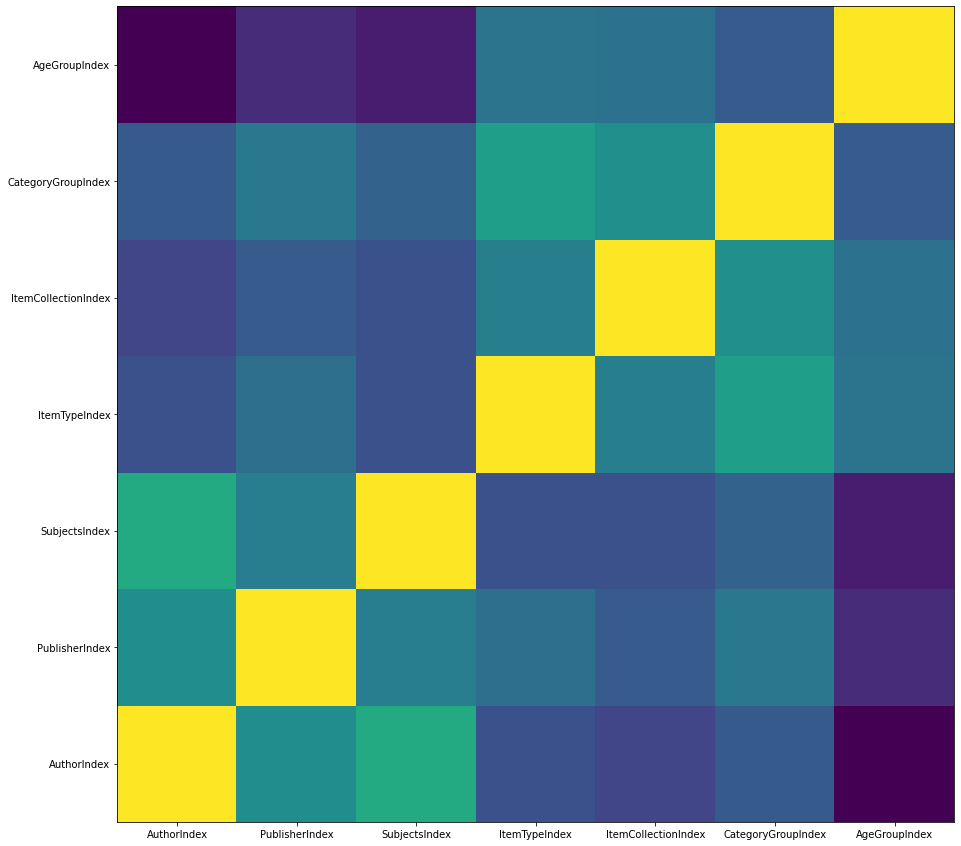

In [86]:
ScatterPlot(df_plot, 15, 15)

### Clear some objects from memory

In [87]:
del item_collection_dfraw_interest_clean1, library_collection_dfraw_interest_clean1, item_collection_dfraw_interest, library_collection_dfraw_interest, library_collection_dfraw, item_collection_dfraw

## Prediction Model

### Train/test split

In [ ]:
df_train, df_test = df_final.randomSplit([0.8, 0.2], seed=42)

#df_train.cache()

#[df_train.count(), df_test.count(), df_final.count()]

### Feature Transformation

In [ ]:
vec_assembler = VectorAssembler(inputCols=index_output_cols, outputCol="features")
vec_df_train = vec_assembler.transform(df_train)

In [ ]:
vec_df_train_cols = index_output_cols + ["features"]
vec_df_train.select(vec_df_train_cols).show()

### Linear Regression

In [ ]:
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, featuresCol="features")
lr_model = lr.fit(vec_df_train)

### Model Inspection 

In [ ]:
print("Coeficcients: %s" % str(lr_model.coefficients))
print("Intercept: %s" % str(lr_model.intercept))

### ML Pipeline

In [ ]:
pipeline = Pipeline=[vec_assembler, lr_model]

pipeline_model=pipeline.fit(df_train)

### Applying to the test set

In [ ]:
df_prediction = pipeline_model.transform(df_test)

df_prediction.select("features","label","prediction").show

### Visual Analysis

In [ ]:
df_main.printSchema()

Reading the main dataset csv file and the auxiliary table to datafames

In [ ]:
df_main = spark.read.format("csv")\
.schema(customSchema)\
.load("library-collection-inventory-sample.csv")
df_main.dataframeName='seattle-library-sample'

df_item_collection = spark.read.format("csv")\
.option("header","true")\
.option("inferSchema", "true")\
.load("ItemCollection.csv")
df_item_collection.dataframeName='item-collection'

df_main.cache()
df_item_collection.cache()

Show schemas for both dataframes

In [ ]:
df_main.printSchema()
df_item_collection.printSchema()
print("Number of columns of the main dataframe: " + str(len(df_main.columns)))
print("Number of columns of the auxiliary dataframe: " + str(len(df_item_collection.columns)))

To cross all the information we will join both dataframes through the item collection code

In [ ]:
df_main_join_df_item_collection = df_main.join(df_item_collection, df_main.ItemCollection == df_item_collection.Code)


Check some data in the data frame

In [ ]:
pd.DataFrame(df_main_join_df_item_collection.take(5), columns=df_main_join_df_item_collection.columns)

In [ ]:
df_aux=df_main.agg(*(countDistinct(col(c)).alias(c) for c in df_main.columns))
pd.set_option('display.max_columns', None)
pd.DataFrame(df_aux.take(5), columns=df_aux.columns)

In [ ]:
#pd.DataFrame(df_aux.take(5), columns=df_aux.columns).

In [ ]:
df_main_join_df_item_collection.printSchema()

In [ ]:
#df_main_join_df_item_type.select("categoryGroup").distinct().show()
#df_main_join_df_item_type.select("categoryGroup").distinct().count()
df_main_join_df_item_collection.select("categoryGroup").distinct().show()
print(df_main_join_df_item_collection.select("categoryGroup").distinct().count())

df_main_join_df_item_collection.select("Subjects").distinct().show()
print(df_main_join_df_item_collection.select("Subjects").distinct().count())

df_main_join_df_item_collection.select("ItemType").distinct().show()
print(df_main_join_df_item_collection.select("ItemType").distinct().count())

df_main_join_df_item_collection.select("ItemCollection").distinct().show()
print(df_main_join_df_item_collection.select("ItemCollection").distinct().count())

df_main_join_df_item_collection.select("ItemLocation").distinct().show()
print(df_main_join_df_item_collection.select("ItemLocation").distinct().count())

In [ ]:
df_main_join_df_item_collection=df_main_join_df_item_collection.where("FormatSubgroup=='Book'")

In [ ]:
df_main_join_df_item_collection.select("FormatSubgroup").distinct().show(truncate=False)

In [ ]:
df_main_join_df_item_collection.printSchema()

In [ ]:
cols_to_drop = ["FloatingItem", "BibNum", "Title", "ISBN", "PublicationYear", "ReportDate", "ItemCount", "ReportDate", "CodeType", "Description", "CollectionInventoryIncluded", "FormatGroup", "FormatSubgroup"]
cols_of_interest = [x for x in df_main_join_df_item_collection.columns if x not in cols_to_drop]

In [ ]:
print(cols_to_drop)
print(cols_of_interest)

In [ ]:
#rawcols = df_main.columns
#len(rawcols)

In [ ]:
# Tratar subjects, publisher e author
for col in cols_of_interest:
    df_main_join_df_item_collection.select(col).show(10, truncate=False)

In [ ]:
print(df_main_join_df_item_collection.select("Subjects").count())
print(df_main_join_df_item_collection.select("Subjects").distinct().count())

In [ ]:
print(df_main_join_df_item_collection.select("Author").count())
print(df_main_join_df_item_collection.select("Author").distinct().count())

In [ ]:
print(df_main_join_df_item_collection.select("Publisher").count())
print(df_main_join_df_item_collection.select("Publisher").distinct().count())

In [ ]:
df_main_join_df_item_collection=df_main_join_df_item_collection.select(cols_of_interest)

In [ ]:
# Limpar nulls
df_main_join_df_item_collection=df_main_join_df_item_collection.dropna()
df_main_join_df_item_collection.count()

In [ ]:
df_main_join_df_item_collection.printSchema()

In [ ]:
# 1 - StringIndexer

age_group_indexer = StringIndexer(inputCol="AgeGroup", outputCol="AgeGroupIndex")
category_group_indexer = StringIndexer(inputCol="CategoryGroup", outputCol="CategoryGroupIndex")
code_indexer = StringIndexer(inputCol="Code", outputCol="CodeIndex")
category_subgroup_indexer = StringIndexer(inputCol="CategorySubgroup", outputCol="CategorySubgroupIndex")
item_collection_indexer = StringIndexer(inputCol="ItemCollection", outputCol="ItemCollectionIndex")#Fits a model to the input dataset with optional parameters.
item_type_indexer = StringIndexer(inputCol="ItemType", outputCol="ItemTypeIndex")
item_location_indexer = StringIndexer(inputCol="ItemLocation", outputCol="ItemLocationIndex")
author_indexer = StringIndexer(inputCol="Author", outputCol="AuthorIndex")
subjects_indexer = StringIndexer(inputCol="Subjects", outputCol="SubjectsIndex")
publisher_indexer = StringIndexer(inputCol="Publisher", outputCol="PublisherIndex")

df_final = item_collection_indexer.fit(df_main_join_df_item_collection).transform(df_main_join_df_item_collection)
df_final = item_type_indexer.fit(df_final).transform(df_final)
df_final = item_location_indexer.fit(df_final).transform(df_final)
df_final = author_indexer.fit(df_final).transform(df_final)
df_final = subjects_indexer.fit(df_final).transform(df_final)
df_final = publisher_indexer.fit(df_final).transform(df_final)
df_final = category_group_indexer.fit(df_final).transform(df_final)
df_final = code_indexer.fit(df_final).transform(df_final)
df_final = category_subgroup_indexer.fit(df_final).transform(df_final)
df_final = age_group_indexer.fit(df_final).transform(df_final)

In [ ]:
df_final.printSchema()

In [ ]:
# 2 - OneHotEncoder
onehotencoder_item_collection_vector = OneHotEncoder(inputCol="ItemCollectionIndex", outputCol="ItemCollectionVec")
onehotencoder_item_type_vector = OneHotEncoder(inputCol="ItemTypeIndex", outputCol="ItemTypeVec")
onehotencoder_item_location_vector = OneHotEncoder(inputCol="ItemLocationIndex", outputCol="ItemLocationVec")
onehotencoder_author_vector = OneHotEncoder(inputCol="AuthorIndex", outputCol="AuthorVec")
onehotencoder_subjects_vector = OneHotEncoder(inputCol="SubjectsIndex", outputCol="SubjectsVec")
onehotencoder_age_group_vector = OneHotEncoder(inputCol="AgeGroupIndex", outputCol="AgeGroupVec")
onehotencoder_category_subgroup_vector = OneHotEncoder(inputCol="CategorySubgroupIndex", outputCol="CategorySubgroupVec")
onehotencoder_code_vector = OneHotEncoder(inputCol="CodeIndex", outputCol="CodeVec")
onehotencoder_category_group_vector = OneHotEncoder(inputCol="CategoryGroupIndex", outputCol="CategoryGroupVec")
onehotencoder_publisher_vector = OneHotEncoder(inputCol="PublisherIndex", outputCol="PublisherVec")

df_final = onehotencoder_item_collection_vector.fit(df_final).transform(df_final)
df_final = onehotencoder_item_type_vector.fit(df_final).transform(df_final)
df_final = onehotencoder_item_location_vector.fit(df_final).transform(df_final)
df_final = onehotencoder_author_vector.fit(df_final).transform(df_final)
df_final = onehotencoder_subjects_vector.fit(df_final).transform(df_final)
df_final = onehotencoder_publisher_vector.fit(df_final).transform(df_final)
df_final = onehotencoder_age_group_vector.fit(df_final).transform(df_final)
df_final = onehotencoder_category_subgroup_vector.fit(df_final).transform(df_final)
df_final = onehotencoder_category_group_vector.fit(df_final).transform(df_final)
df_final = onehotencoder_code_vector.fit(df_final).transform(df_final)

pd.DataFrame(df_final.take(5), columns=df_final.columns)

In [ ]:
df_final.printSchema()

In [ ]:
pd.DataFrame(df_final.take(5), columns=df_final.columns)

In [ ]:
df_train, df_test = df_final.randomSplit([0.8, 0.2], seed=42)

In [ ]:
df_train.printSchema()

In [ ]:
# 3 - VectorAssembler
vec_assembler = VectorAssembler(inputCols=["ItemCollectionVec",
 "ItemTypeVec",
 "ItemLocationVec",
 "AuthorVec",
 "SubjectsVec",
 "PublisherVec",
 "AgeGroupVec",
 "CategorySubgroupVec",
 "CodeVec"], outputCol="features")
vec_df_train = vec_assembler.transform(df_train)

In [ ]:
# Matriz de Correlação
# convert to vector column first
#df_vector = vec_assembler.transform(df_train).select("features")
#matrix = Correlation.corr(df_vector, "features")

In [ ]:
vec_df_test = vec_assembler.transform(df_test)

In [ ]:
# create the trainer and set its parameters
nb = NaiveBayes(labelCol='CategoryGroupIndex', smoothing=1.0)
# train the model
model = nb.fit(vec_df_train)

In [ ]:
predictions = model.transform(vec_df_test)
predictions.show(truncate=False)

pd.DataFrame(predictions.take(5), columns=predictions.columns)
predictions.select("prediction").distinct().show()

In [ ]:
# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="CategoryGroupIndex", predictionCol="prediction",
                                              metricName="accuracy")

In [ ]:
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

In [ ]:
# Compute raw scores on the test set
predictionAndLabels = df_test.rdd.map(lambda lp: (float(model.predict(lp.features)), lp.label))

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="CategoryGroupIndex", predictionCol="prediction",
                                              metricName="truePositiveRateByLabel")

In [ ]:
true_positive = evaluator.evaluate(predictions)
print("Test set truePositiveRateByLabel = " + str(true_positive))

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="CategoryGroupIndex", predictionCol="prediction",
                                              metricName="hammingLoss")

In [ ]:
hamming_loss = evaluator.evaluate(predictions)
print("Test set hamming_loss = " + str(hamming_loss))

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="CategoryGroupIndex", predictionCol="prediction",
                                              metricName="logLoss")

In [ ]:
log_loss = evaluator.evaluate(predictions)
print("Test set log_loss = " + str(log_loss))

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="CategoryGroupIndex", predictionCol="prediction",
                                              metricName="falsePositiveRateByLabel")

In [ ]:
false_positive = evaluator.evaluate(predictions)
print("Test set falsePositiveRateByLabel = " + str(false_positive))

In [ ]:
rf = RandomForestClassifier(labelCol="CategoryGroupIndex",
                            featuresCol="features", 
                            numTrees = 100, 
                            maxDepth = 4, 
                            maxBins = 32)
# Train model with Training Data
rfModel = rf.fit(vec_df_train)
predictions = rfModel.transform(vec_df_test)
predictions.filter(predictions['prediction'] == 0) \
    .select("Author","CategoryGroup","CategoryGroupIndex","Subjects","Publisher","prediction") \
    .orderBy("prediction", ascending=False) \
    .show(n = 10, truncate = 30)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="CategoryGroupIndex", predictionCol="prediction", metricName="accuracy")
evaluator.evaluate(predictions)

In [ ]:
dt = DecisionTreeClassifier(labelCol="CategoryGroupIndex", featuresCol="features")
dtModel = dt.fit(vec_df_train)

In [ ]:
predictions = dtModel.transform(vec_df_test)
predictions.filter(predictions['prediction'] == 0) \
    .select("Author","CategoryGroup","CategoryGroupIndex","Subjects","Publisher","prediction") \
    .orderBy("prediction", ascending=False) \
    .show(n = 10, truncate = 30)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="CategoryGroupIndex", predictionCol="prediction", metricName="accuracy")
evaluator.evaluate(predictions)

In [ ]:
#print(spark.conf.get('spark.driver.maxResultSize'))

In [ ]:
sc=spark.sparkContext

In [ ]:
print(sc._conf.get('spark.driver.memory'))

In [ ]:
%magic 

In [ ]:
%%configure -f {"conf":{"spark.driver.maxResultSize":"2G"}}

In [ ]:
vec_df_train.printSchema()

In [ ]:
#df_b=vec_df_train.select("ItemCollectionVec","PublisherVec","AuthorVec","ItemTypeVec", "ItemLocationVec","SubjectsVec","CategorySubgroupVec","CodeVec", "CategoryGroupVec","features")
df_b=vec_df_train.select("ItemLocationVec","SubjectsVec","CategorySubgroupVec","CodeVec", "CategoryGroupVec","features")
df_b.printSchema()

In [ ]:
r1 = Correlation.corr(df_b, "features").head()

In [ ]:
# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

In [ ]:
precision = evaluator.evaluate(predictions)
print("Test set precision = " + str(precision))

In [ ]:
#df_main_join_df_item_collection.select("Code").distinct().show()
#df_main_join_df_item_collection.select("Code").distinct().count()
#cols_to_drop = ["FloatingItem", "BibNum", "Title", "ISBN", "PublicationYear", "ReportDate", "ItemCount"]
#cols_of_interest = [x for x in rawcols if x not in cols_to_drop]
#cols_of_interest

In [ ]:
df_of_interest = df_main.select(cols_of_interest)
df_of_interest.printSchema()
df_of_interest.show()

In [ ]:
# Drop nulls
df_of_interest_cleaned = df_of_interest.dropna()

In [ ]:
print(df_of_interest.count())
print(df_of_interest_cleaned.count())

In [ ]:
# check the columns again, just the ones of interest, one by one
for col in df_of_interest_cleaned.columns:
    df_of_interest_cleaned.select(col).show(5)

In [ ]:
#df_of_interest_cleaned.select("ItemLocation").distinct().count()
df_of_interest_cleaned.select("ItemLocation").distinct().show(truncate=False)

In [ ]:
cleanfilename = 'cleaned-library-dataset'
df_of_interest_cleaned.write.mode("overwrite").csv(cleanfilename)

In [ ]:
# 1 - StringIndexer
item_collection_indexer = StringIndexer(inputCol="ItemCollection", outputCol="ItemCollectionIndex")#Fits a model to the input dataset with optional parameters.
item_type_indexer = StringIndexer(inputCol="ItemType", outputCol="ItemTypeIndex")
item_location_indexer = StringIndexer(inputCol="ItemLocation", outputCol="ItemLocationIndex")
author_indexer = StringIndexer(inputCol="Author", outputCol="AuthorIndex")
subjects_indexer = StringIndexer(inputCol="Subjects", outputCol="SubjectsIndex")
publisher_indexer = StringIndexer(inputCol="Publisher", outputCol="PublisherIndex")

df_final = item_collection_indexer.fit(df_of_interest_cleaned).transform(df_of_interest_cleaned)
df_final = item_type_indexer.fit(df_final).transform(df_final)
df_final = item_location_indexer.fit(df_final).transform(df_final)
df_final = author_indexer.fit(df_final).transform(df_final)
df_final = subjects_indexer.fit(df_final).transform(df_final)
df_final = publisher_indexer.fit(df_final).transform(df_final)

In [ ]:
# 2 - OneHotEncoder
onehotencoder_item_collection_vector = OneHotEncoder(inputCol="ItemCollectionIndex", outputCol="ItemCollectionVec")
onehotencoder_item_type_vector = OneHotEncoder(inputCol="ItemTypeIndex", outputCol="ItemTypeVec")
onehotencoder_item_location_vector = OneHotEncoder(inputCol="ItemLocationIndex", outputCol="ItemLocationVec")
onehotencoder_author_vector = OneHotEncoder(inputCol="AuthorIndex", outputCol="AuthorVec")
onehotencoder_subjects_vector = OneHotEncoder(inputCol="SubjectsIndex", outputCol="SubjectsVec")
onehotencoder_publisher_vector = OneHotEncoder(inputCol="PublisherIndex", outputCol="PublisherVec")

df_final = onehotencoder_item_collection_vector.fit(df_final).transform(df_final)
df_final = onehotencoder_item_type_vector.fit(df_final).transform(df_final)
df_final = onehotencoder_item_location_vector.fit(df_final).transform(df_final)
df_final = onehotencoder_author_vector.fit(df_final).transform(df_final)
df_final = onehotencoder_subjects_vector.fit(df_final).transform(df_final)
df_final = onehotencoder_publisher_vector.fit(df_final).transform(df_final)

df_final.show()

In [ ]:
df_train, df_test = df_final.randomSplit([0.8, 0.2], seed=42)

In [ ]:
df_train.cache()

In [ ]:
#print number of lines in each part
#[df_train.count(), df_test.count()]

In [ ]:
# 3 - VectorAssembler
vec_assembler = VectorAssembler(inputCols=["ItemTypeVec",
 "ItemLocationVec",
 "AuthorVec",
 "SubjectsVec",
 "PublisherVec"], outputCol="features")
vec_df_train = vec_assembler.transform(df_train)

In [ ]:
vec_df_train.show(truncate=False)

In [ ]:
# Este algoritmo deu merda
# create the trainer and set its parameters
#nb = NaiveBayes(labelCol='ItemCollectionIndex', smoothing=1.0, modelType="multinomial")
# train the model
#model = nb.fit(vec_df_train)

In [ ]:
val dt = new DecisionTreeClassifier()
  .setLabelCol("indexedLabel")
  .setFeaturesCol("indexedFeatures")

In [ ]:
df.printSchema()
cols = df.columns
df.count()

In [ ]:
df.show(2)

In [ ]:
pd.DataFrame(df.take(5), columns=cols)

In [ ]:
df.take(5)

In [ ]:
featureColumns = ['Author','Publisher','ItemType','ItemCollection',
 'ItemLocation']

In [ ]:
responses = df.groupBy('Subjects').count().collect()

In [ ]:
categories = [i[0] for i in responses]
counts = [i[1] for i in responses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='r')
 
plt.ylabel('counts')
plt.title('Stroke')
plt.xticks(ind + width/2., categories)

In [ ]:
df.select("Subjects").distinct().count()

In [ ]:
df.take(50)

In [ ]:
#Count nulls
df.select([count(when(isnan('Subjects') | col('Subjects').isNull() , True))]).show()
df.select([count(when(isnan('ItemType') | col('ItemType').isNull() , True))]).show()
df.select([count(when(isnan('ItemCollection') | col('ItemCollection').isNull() , True))]).show()

In [ ]:
x = df.count()

In [ ]:
x - 8322

In [ ]:
df = df.na.drop(subset=["Subjects"]) ## Drop null values
df = df.na.drop(subset=["ItemType"]) ## Drop null values
df = df.na.drop(subset=["ItemCollection"]) ## Drop null values

In [ ]:
df.count()

In [ ]:
item_collection_indexer = StringIndexer(inputCol="ItemCollection", outputCol="ItemCollectionIndex")#Fits a model to the input dataset with optional parameters.
df1 = item_collection_indexer.fit(df).transform(df)
df1.show()

In [ ]:
#encoder = OneHotEncoder()\
#.setInputCol("ItemCollection")\
#.setOutputCol("ItemCollection")
#encoder.transform(df.select("ItemCollection")).show()

In [ ]:
#onehotencoder to qualificationIndex
onehotencoder_item_collection_vector = OneHotEncoder(inputCol="ItemCollectionIndex", outputCol="ItemCollection_vec")
df11 = onehotencoder_item_collection_vector.fit(df1).transform(df1)
df11.show()

In [ ]:
#Create pipeline and pass all stages
pipeline = Pipeline(stages=[item_collection_indexer,
                            onehotencoder_item_collection_vector
                    ])

In [ ]:
df_transformed = pipeline.fit(df).transform(df)
df_transformed.show()

In [ ]:
df_transformed.select("ItemCollectionIndex").distinct().count()

In [ ]:
#from pyspark.ml.feature import RFormula
#supervised = RFormula(formula="label ~ . + Churn:TotalCharges + Churn:MonthlyCharges + Churn:SeniorCitizen")